# 建筑年代模型选择和训练
[Part4.对建筑年代进行深度学习训练和预测——《通过深度学习了解建筑年代和风格》](https://cdn.renhai-lab.tech/archives/Understanding_architecture_age_and_style_through_deep_learning_part4-1)

In [2]:
from torchvision.models import densenet121
from torchvision.models.densenet import DenseNet121_Weights

# 加载预训练的DenseNet121模型
model = densenet121(weights=DenseNet121_Weights.DEFAULT)
# UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
# 打印模型结构可以看到dense blocks的结构
# print(model)


使用 torchinfo.summary() 查看模型信息

In [3]:
from torchinfo import summary
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1024, 7, 7]     --                   True
│    └─Conv2d (conv0)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    └─ReLU (relu0)                           [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]     [32, 32, 56, 56]    

## 特征提取

在迁移学习中，通常有两种策略：微调（Fine-tuning）和特征提取（Feature Extraction）。在您提供的代码片段中，实际上采用的是特征提取方法，而不是仅仅冻结最后一层。下面我将解释这两种方法，并指出您的代码中的具体做法。

1. 特征提取（Feature Extraction）:
在这种方法中，我们保留预训练模型的所有权重不变，只更新我们添加的最后几层（通常是全连接层或分类器）的权重。
在PyTorch中，冻结模型的层。这意味着我们不会在训练过程中更新它们的权重。我们将冻结所有层，除了最后一层全联接层，也是分类起。我们将挑战最后一层上训练我们的模型。这是特征提取的典型做法。

2. 微调（Fine-tuning）:
在微调中，我们不仅更改最后几层的权重，还继续更新预训练模型的全部或部分权重。
这通常通过解冻整个模型或模型的一部分，并在训练过程中使用较小的学习率来实现，以避免丢失有用的特征。

文章提到了使用预训练的模型并对其进行微调，但是经过我的测试，直接使用特征提取效果也不错，所以我们直接使用特征提取的方法。

In [4]:
# 冻结所有层
for param in model.parameters():
    param.requires_grad = False
    
# 但是，我们想训练模型的最后一层，所以我们解冻这一层
for param in model.classifier.parameters():
    param.requires_grad = True

使用 torchinfo.summary() 重新查看模型信息

In [5]:
from torchinfo import summary
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1024, 7, 7]     --                   False
│    └─Conv2d (conv0)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (relu0)                           [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]     [32, 32, 56, 

我们可以看到，我们的模型现在只有最后一层分类器的参数是可训练的。可训练参数量也减少了很多，从7,978,856减少到了1,025,000。

我们将从1000个类别中预测，但是我们的数据集只有9个建筑年代类别。因此，我们需要更改最后一层的输出特征数。
[
    "pre-1652",
    "1653–1705",
    "1706–1764",
    "1765–1845",
    "1846–1910",
    "1911–1943",
    "1944–1977",
    "1978–1994",
    "1995–2023",
]

model的初始输入形状为[batch_size, 3, 224, 224]

In [6]:
# 查看模型所有层的名称
for name, module in model.named_children():
    print(name)


features
classifier


In [7]:
# 查看features中的层
for name, module in model.features.named_children():
    print(name)

conv0
norm0
relu0
pool0
denseblock1
transition1
denseblock2
transition2
denseblock3
transition3
denseblock4
norm5


In [8]:
## 修改最后一层的输出特征数
# 获取最后一层的输入特征数
num_features = model.classifier.in_features
num_features

1024

In [9]:
# 修改为9类建筑年代的输出特征数
import torch.nn as nn
model.classifier = nn.Linear(num_features, 9)
model.classifier

Linear(in_features=1024, out_features=9, bias=True)

In [10]:
### 可选，欠拟合需要解冻更多层

In [11]:
# 假设我们要解冻最后的两个Dense层，这里我们假设DenseNet的features模块是一个名为`denseblock4`的Sequential模块
# 并且我们也要训练分类器模块
for name, module in model.named_children():
    if name in ['denseblock4', 'classifier']:
        for param in module.parameters():
            param.requires_grad = True

In [12]:
from torchinfo import summary
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [32, 3, 224, 224]    [32, 9]              --                   Partial
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1024, 7, 7]     --                   False
│    └─Conv2d (conv0)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (relu0)                           [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]     [32, 32, 56, 

## 使用自定义数据集加载图像数据(使用ImageFolder，并且对测试集应用转换)

由于我们的数据采用标准图像分类格式，因此我们可以使用类 [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder) 。
![我们的文件夹格式](https://image-1315363329.cos.ap-shanghai.myqcloud.com/lessons/202310211333844.png)

### 加载训练和测试数据集

In [30]:
from torch import manual_seed
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets

# 加载图片
img_root = "../../data/GSV/clip"
all_data = datasets.ImageFolder(root=img_root) # 不要应用tranform

# 拆分数据
manual_seed(8)
train_size = int(0.8 * len(all_data))
test_size = len(all_data) - train_size
train_data_raw, test_data_raw = random_split(all_data, [train_size, test_size])

In [31]:
# 数据集长度
print(len(train_data_raw), len(test_data_raw) )

63656 15915


## 查看数据集的标签

当您使用ImageFolder从文件夹加载数据时，它会自动根据子文件夹的名称为每个类别分配一个标签。

In [32]:
# 获取类名列表
class_names = all_data.classes
print(class_names)

['1653–1705', '1706–1764', '1765–1845', '1846–1910', '1911–1943', '1944–1977', '1978–1994', '1995–2023', 'pre-1652']


In [33]:
# 数据集的类别的字典形式
class_dict = all_data.class_to_idx
class_dict

{'1653–1705': 0,
 '1706–1764': 1,
 '1765–1845': 2,
 '1846–1910': 3,
 '1911–1943': 4,
 '1944–1977': 5,
 '1978–1994': 6,
 '1995–2023': 7,
 'pre-1652': 8}

### 数据增强并绘制转换前后的图
重新进行数据转换，添加数据增强
并且只对训练数据进行数据增强，测试数据不进行数据增强

In [34]:
from torchvision import transforms

train_transform  = transforms.Compose([transforms.Resize(size=(224, 224), antialias=True),
                                     transforms.RandomHorizontalFlip(p=0.2),
                                     transforms.RandomVerticalFlip(p=0.2),
                                     transforms.RandomRotation(degrees=45),
                                     transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
# 定义测试数据的转换（如果需要的话，这里我们不应用任何转换）
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

In [35]:
#对dataset进行索引
# 我们可以对 train_data 和 test_data 对 Dataset 进行索引来查找样本及其目标标签。

img, label = train_data_raw[0][0], test_data_raw[0][1]
print(f"Image tensor:\n{img}")

Image tensor:
<PIL.Image.Image image mode=RGB size=512x512 at 0x1FB7FAE6510>


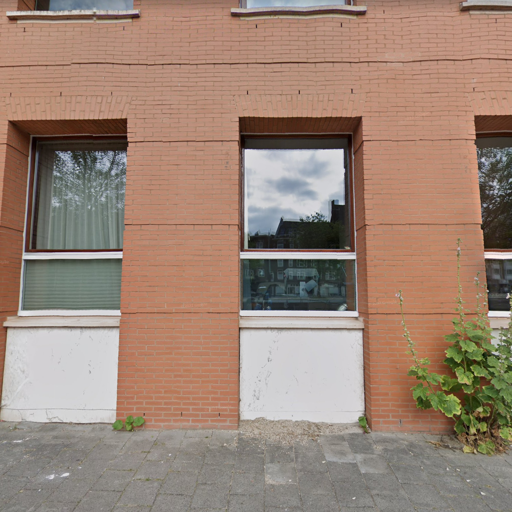

In [36]:
img

In [37]:
type(img)

PIL.Image.Image

## 查看各类别数据占比,处理不平衡的数据集
处理不平衡的数据集，在训练集上使用WeightedRandomSampler

In [38]:
import numpy as np
# 获取每个类的样本数，以便进一步处理
class_counts = np.bincount([label for _, label in all_data.samples])
class_counts

array([  830,  1821,  1310, 14331, 32280, 10176,  6992, 10634,  1197],
      dtype=int64)

Text(0, 0.5, 'Number of images')

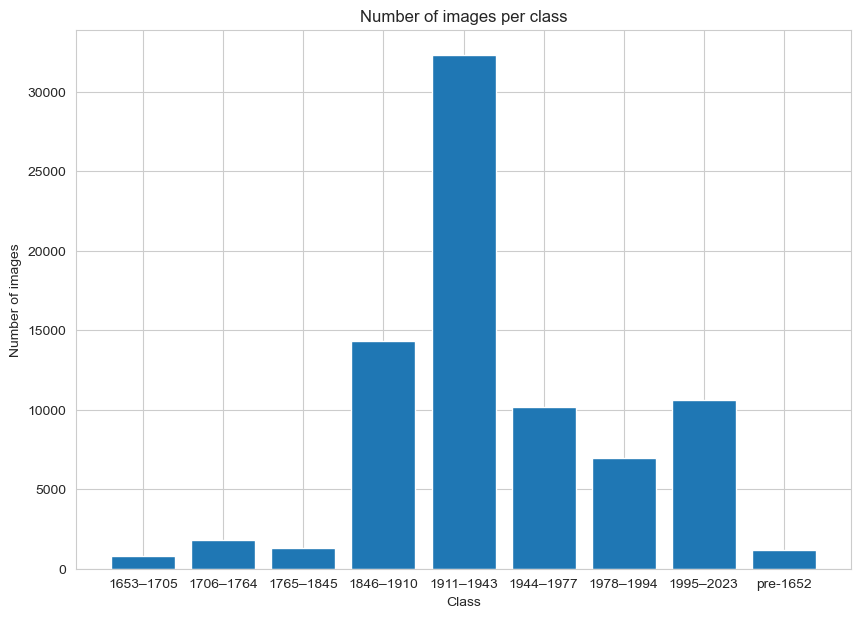

In [39]:
# 绘制直方图
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.bar(x=class_names, height=class_counts)

# 定义title
plt.title("Number of images per class")

# 定义x y轴label
plt.xlabel("Class")
plt.ylabel("Number of images")

In [40]:
total_count = len(all_data)
total_count

79571

In [41]:
# 计算各类别的样本占比
class_proportions = [class_counts[i]/total_count for i in range(len(class_counts))]
# 转换成百分比 取两位小数
class_proportions = [round(i*100, 2) for i in class_proportions]
class_proportions

[1.04, 2.29, 1.65, 18.01, 40.57, 12.79, 8.79, 13.36, 1.5]

In [78]:
all_labels = [label for _, label in all_data.samples]
class_counts = np.bincount(all_labels) # 获取每个类的样本数，以便进一步处理
total_count = len(all_data) # 获取总样本数
original_weights = [total_count / class_counts[i] for i in range(len(class_counts))] # 计算每个类的权重 [95.86867469879518, 43.69632070291049, 60.7412213740458, 5.552368990300747, 2.46502478314746, 7.819477201257862, 11.38029176201373, 7.482697009591875, 66.47535505430243]
print("original_weights：", original_weights )

original_weights： [95.86867469879518, 43.69632070291049, 60.7412213740458, 5.552368990300747, 2.46502478314746, 7.819477201257862, 11.38029176201373, 7.482697009591875, 66.47535505430243]


In [79]:
# 计算最大最小的权重
max_weight = max(original_weights)
min_weight = min(original_weights)

In [80]:
# 计算最大权重和最小权重之间的差异
diff_weight = max_weight - min_weight

# 计算要添加到每个较小权重的增量（例如，差异的一部分）
increment = diff_weight * 0.1

# 调整权重，为较小的权重增加增量
adjusted_weights = [weight + increment if weight + increment <= max_weight else weight for weight in
                    original_weights]

print("adjusted_weights：", adjusted_weights)

adjusted_weights： [95.86867469879518, 53.03668569447527, 70.08158636561058, 14.892733981865518, 11.805389774712232, 17.159842192822634, 20.720656753578503, 16.823062001156647, 75.8157200458672]


In [81]:
# random_split返回的是Subset对象，我们可以通过.indices属性来获取原始数据集中的索引
train_indices = train_data_raw.indices

# 现在，我们使用这些索引来从全部标签列表中提取训练集标签
train_labels = [all_labels[idx] for idx in train_indices]

In [84]:
train_labels[:10]

[5, 7, 6, 4, 4, 4, 7, 4, 3, 4]

In [83]:
# 计算训练样本权重
train_sample_weights = [adjusted_weights[label] for label in train_labels]
train_sample_weights[:10]

[17.159842192822634,
 16.823062001156647,
 20.720656753578503,
 11.805389774712232,
 11.805389774712232,
 11.805389774712232,
 16.823062001156647,
 11.805389774712232,
 14.892733981865518,
 11.805389774712232]

In [85]:
from torch.utils.data import DataLoader, WeightedRandomSampler
# 创建加权随机采样器以进行重采样
train_sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_sample_weights), replacement=True)

In [86]:
# 创建一个自定义数据集类，它接受一个Subset和一个transform
from PIL import Image

class CustomDataset(Dataset):
    """包装PyTorch数据集以应用转换。"""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.imgs = subset.dataset.imgs

    def __getitem__(self, index):
        img, y = self.subset[index]

        if self.transform:
            img = self.transform(img)

        return img, y

    def __len__(self):
        return len(self.subset)

In [87]:
# 使用自定义数据集类应用转换
train_data = CustomDataset(train_data_raw, transform=train_transform)
test_data = CustomDataset(test_data_raw, transform=test_transform)

In [88]:
# 创建DataLoader
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,sampler=train_sampler)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

## 进行训练

In [89]:
import torch
# 最初选择的定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [90]:
# 我后面更换了优化器
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)  # 使用更高的初始学习率
# 引入学习率调度器
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 每10个epochs降低当前学习率的10%

我们使用[pytorch迁移学习](https://cdn.renhai-lab.tech/archives/DL-06-pytorch-transfer_learning#4.%20%E8%AE%AD%E7%BB%83%E6%A8%A1%E5%9E%8B)中定义的train_step()、test_step()和train()函数来训练和测试模型,关于这些深度学习的更多知识qinglong浏览《使用PyTorch进行深度学习系列》(https://cdn.renhai-lab.tech/archives/DL-Home)课程。

In [91]:
import copy
import os
from typing import Dict, List, Tuple
from torch.utils.tensorboard import SummaryWriter
import torch
from tqdm.auto import tqdm


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """对PyTorch模型进行单个epoch的训练。

    将目标PyTorch模型设置为训练模式，然后执行所有必要的训练步骤（前向传播、损失计算、优化器步骤）。

    参数：
    model：要训练的PyTorch模型。
    dataloader：用于训练模型的DataLoader实例。
    loss_fn：要最小化的PyTorch损失函数。
    optimizer：帮助最小化损失函数的PyTorch优化器。
    device：计算设备（例如："cuda"或"cpu"）。

    返回：
    训练损失和训练准确率的元组。
    格式为（train_loss，train_accuracy）。例如：

    (0.1112，0.8743)
    """
    # 将模型设置为训练模式
    model.train()

    # 设置训练损失和训练准确率的初始值
    train_loss, train_acc = 0, 0

    # 遍历数据加载器中的数据批次
    for batch, (X, y) in enumerate(dataloader):
        # 将数据发送到目标设备
        X, y = X.to(device), y.to(device)

        # 1. 前向传播
        y_pred = model(X)

        # 2. 计算并累加损失
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. 优化器梯度清零
        optimizer.zero_grad()

        # 4. 反向传播计算梯度
        loss.backward()

        # 5. 优化器更新参数
        optimizer.step()

        # 计算并累加准确率指标
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)



    # 调整指标以获得每个批次的平均损失和准确率
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """对PyTorch模型进行单个epoch的测试。

    将目标PyTorch模型设置为“eval”模式，然后在测试数据集上执行前向传播。

    参数：
    model：要测试的PyTorch模型。
    dataloader：用于测试模型的DataLoader实例。
    loss_fn：用于计算测试数据上的损失的PyTorch损失函数。
    device：计算设备（例如："cuda"或"cpu"）。

    返回：
    测试损失和测试准确率的元组。
    格式为（test_loss，test_accuracy）。例如：

    (0.0223，0.8985)
    """
    # 将模型设置为评估模式
    model.eval()

    # 设置测试损失和测试准确率的初始值
    test_loss, test_acc = 0, 0

    # 打开推理上下文管理器
    with torch.inference_mode():
        # 遍历DataLoader中的数据批次
        for batch, (X, y) in enumerate(dataloader):
            # 将数据发送到目标设备
            X, y = X.to(device), y.to(device)

            # 1. 前向传播
            test_pred_logits = model(X)

            # 2. 计算并累加损失
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # 计算并累加准确率
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    # 调整指标以获得每个批次的平均损失和准确率
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train(
        model: torch.nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        scheduler: torch.optim.lr_scheduler._LRScheduler,  # 新增：学习率调度器
        epochs: int,
        device: torch.device,
        model_save_path: str,  # 新增：模型保存路径
        save_interval: int = 5,  # 新增：保存间隔（以epochs为单位）
        logs_path: str = '/root/tb-logs/train_experiment',
) -> Dict[str, List]:
    """训练和测试PyTorch模型。

    将目标PyTorch模型通过train_step()和test_step()函数进行多个epoch的训练和测试，
    在同一个epoch循环中训练和测试模型。

    计算、打印和存储评估指标。

    参数：
    model：要训练和测试的PyTorch模型。
    train_dataloader：用于训练模型的DataLoader实例。
    test_dataloader：用于测试模型的DataLoader实例。
    optimizer：帮助最小化损失函数的PyTorch优化器。
    loss_fn：用于计算两个数据集上的损失的PyTorch损失函数。
    epochs：要训练的epoch数。
    device：计算设备（例如："cuda"或"cpu"）。
    model_save_path：模型保存路径。
    save_interval：保存模型的间隔epoch数。

    返回：
    包含训练和测试损失以及训练和测试准确率指标的字典。
    每个指标都有一个列表值，表示每个epoch的指标。
    格式为：{train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    例如，如果训练2个epochs：
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """

    writer = SummaryWriter(logs_path)

    # 确保保存路径存在
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0  # 初始化最佳准确度

    # 创建空的结果字典
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }

    # 确保模型在目标设备上
    model.to(device)

    # 循环进行训练和测试步骤，直到达到指定的epoch数
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        # 记录训练的计算平均损失和准确度
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)

        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # 记录测试的计算平均损失和平均准确度
        writer.add_scalar('Loss/test', test_loss, epoch)
        writer.add_scalar('Accuracy/test', test_acc, epoch)

        # 打印当前进度
        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 性能提升时保存模型
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), os.path.join(model_save_path, 'best_model.pth'))

        # 定期保存模型
        if epoch % save_interval == 0:
            torch.save(model.state_dict(), os.path.join(model_save_path, f'model_epoch_{epoch}.pth'))

        # 更新结果字典
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # 在每个epoch结束时步进调度器
        scheduler.step()
        # 可选：打印当前学习率
        current_lr = scheduler.get_last_lr()
        print(f"Epoch {epoch + 1}: Current learning rate: {current_lr}")

    # 在训练结束后，我们也可以选择加载最佳模型权重
    model.load_state_dict(best_model_wts)

    # 在训练结束时返回填充的结果字典
    return results


In [92]:
# 你也可以保存上面三个函数到py文件中，然后导入上述三个函数
import sys
# 添加上一级目录到sys.path，在notebook中需要进行此操作才能从上层文件导入
sys.path.append("../../")

from my_tools.engine import train_step, test_step, train

接下来进行训练：

In [93]:
# 设置随机种子
torch.manual_seed(8)
torch.cuda.manual_seed(8)

# 清空cuda缓存
torch.cuda.empty_cache()


# 开始计时器
from timeit import default_timer as timer 
start_time = timer()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 开始训练并且保存结果
results = train(model=model,
                train_dataloader=train_loader,
                test_dataloader=test_loader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                scheduler=scheduler,  
                epochs=40,
                device=device,
                model_save_path="models/weights",
                save_interval=1,
                logs_path='../tensorboard-logs/1st'  # autodl的tensorboard路径日志:/root/tf-logs
                )

# 返回时间
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/40 [00:00<?, ?it/s]


KeyboardInterrupt



我们看到准确度在上升，损失在下降，可以增加训练次数。


### 通过绘制损失曲线来评估模型

In [ ]:
# 从 helper_functions.py 获取 plot_loss_curves（） 函数，如果没有文件，请下载文件
try:
    from my_tools.helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 通过TensorBoard实时查看模型表现

TensorBoard 是一个可视化工具，用于深度学习训练过程中的指标跟踪、模型图形查看、嵌入式可视化等。它最初是为 TensorFlow 设计的，但也可以与其他框架一起使用，

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# 定义 TensorBoard writer
writer = SummaryWriter('runs/experiment_1')  # 'runs/experiment_1' 是日志文件将被保存的目录

### 记录数据：
在训练循环中，你可以添加代码来记录想要监控的任何数据，如损失、准确率等。

In [ ]:
for epoch in range(num_epochs):
    for batch in dataloader:
        # ... 生成输出并计算损失等

        # 假设 loss 是你的损失变量
        writer.add_scalar('Loss/train', loss, epoch)
        # ... 其他代码，例如优化器步骤等


你还可以添加更多的 TensorBoard 功能，比如记录模型图、多个指标或者甚至是图像。

# 查看 TensorBoard：
## 在你的终端或命令提示符中，导航到上面代码中 TensorBoard 日志文件所在的父目录，并启动 TensorBoard：
`tensorboard --logdir=runs`

In [ ]:
# 在训练循环结束后，确保关闭 writer 以释放资源。
writer.close()

##  对测试集中的图像进行预测

In [51]:
from typing import List, Tuple
import matplotlib.pyplot as plt
import torchvision
from PIL import Image


# 反标准化函数
def unnormalize(tensor_image):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    return tensor_image * std + mean


# 1. 接受经过训练的模型、类名列表、目标图像的文件路径、图像大小、转换和目标设备。
def pred_and_plot_image(model, image_path, class_names, device):
    
    # 2. 使用 PIL.Image.open() 打开图像
    img = Image.open(image_path)
        
    # 3. 为图像创建一个转换（这将默认为我们上面创建的 manual_transforms 或者它可以使用从 weights.transforms() 生成的转换）。
    # 预设的转换操作
    image_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    ### 预测图形 ### 
    # 4. 确保该模型位于目标设备上。
    model.to(device)

    # 5. 使用 model.eval() 打开模型评估模式（这会关闭 nn.Dropout() 等层，因此它们不用于推理）和推理模式上下文管理器。
    model.eval()
    with torch.inference_mode():
        # 6. 使用步骤 3 中进行的变换来变换目标图像，并使用 torch.unsqueeze(dim=0) 添加额外的批量维度，以便我们的输入图像具有形状 [batch_size, color_channels, height, width] 。
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # 7. 通过将图像传递给模型来对图像进行预测，确保它位于目标设备上。
        target_image_pred = model(transformed_image.to(device))

    # 8. 使用 torch.softmax() 将模型的输出 logits 转换为预测概率
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. 使用 torch.argmax() 将模型的预测概率转换为预测标签。
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    true_label = image_path.split("/")[-2]
    
    # 10. 使用 matplotlib 绘制图像，并将标题设置为步骤 9 中的预测标签和步骤 8 中的预测概率
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"True: {true_label} | Pred: {class_names[target_image_pred_label.item()]} | Prob: {target_image_pred_probs.max().item():.3f}")

    plt.axis('off')


In [52]:
image_path = train_data.imgs[0]  # 获取第一个图像的路径
print(image_path)

('../../data/GSV/clip\\1653–1705\\subset_1--11739--363100012571333--2023-03.png', 0)


In [53]:
# 随机选择5个图形
import random
random_test_samples = random.sample(train_data.imgs, 5)
random_test_samples

[('../../data/GSV/clip\\1846–1910\\subset_3--42709--363100012167706--2022-03.png',
  3),
 ('../../data/GSV/clip\\1911–1943\\subset_3--21013--363100012230619--2019-06.png',
  4),
 ('../../data/GSV/clip\\1706–1764\\subset_3--39550--363100012168007--2021-03.png',
  1),
 ('../../data/GSV/clip\\1944–1977\\subset_1--16930--363100012134568--2018-05.png',
  5),
 ('../../data/GSV/clip\\1911–1943\\subset_1--2265--363100012069820--2018-07.png',
  4)]

In [54]:
# 转换成列表
random_test_samples = [sample[0] for sample in random_test_samples]

In [55]:
for image_path in random_test_samples:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        device=device)

NameError: name 'device' is not defined

## 保存和加载模型

In [ ]:
## 保存
model_weights_path = "arch_age_epoch.pth"
torch.save(model.state_dict(), model_weights_path)

In [ ]:
## 如果需要加载
from torchvision.models import densenet121

# 实例化模型（确保架构与之前保存的模型完全相同）
model = densenet121(weights=DenseNet121_Weights.DEFAULT)

# 加载之前保存的 state_dict
model.load_state_dict(torch.load(model_weights_path))

# 确保将模型设为评估模式，这在推理时很重要
model.eval()